In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import expon
from scipy.integrate import quad
import copy

## Testing python's functionality

In [2]:
# Test to see if python will pass the same memory address
# Spoilers it does which is very nice :P

class SharedVariable():
    def __init__(self, value):
        self.value = value
class UserClass():
    created = 1
    def __init__(self, shared_variable):
        self.SharedVariable_class = shared_variable
        self.id = UserClass.created
        UserClass.created += 1
# Make the object to be passed        
passed_obj = SharedVariable('hello')

# Make the objects that get the class passed to
obj1 = UserClass(passed_obj)
obj2 = UserClass(passed_obj)
display(obj1.id)
display(obj2.id) 

# Check if changing it in one object will affect the other
display(obj1.SharedVariable_class.value)
obj1.SharedVariable_class.value = 'goodbye'
display(obj2.SharedVariable_class.value)

1

2

'hello'

'goodbye'

## Map class

In [3]:
# Read in raw data
path_to_data = os.path.join(os.getcwd(), "data\\SRTM_RAMP2_TOPO_2000-02-11_rgb_3600x1800.CSV")
raw_data = pd.read_csv(path_to_data, header=None).to_numpy()
n_emptyValues = sum(np.isnan(raw_data).flatten())
raw_data = raw_data[420:560, 730:920]

# Make sure the data doesn't have outliers
clip_mask = raw_data < np.percentile(raw_data, 1)
data = raw_data
data[clip_mask] = np.percentile(raw_data, 1)

# Squish data and scale it
data = np.log(data)
dMax = np.max(data)
dMin = np.min(data)
scaled_data = (data - dMin) / (dMax-dMin)
# scaled_data = (scaled_data - 1) * -1

# Compute gradient and how many empty values it has
derivative_data = np.gradient(raw_data)

<AxesSubplot:>

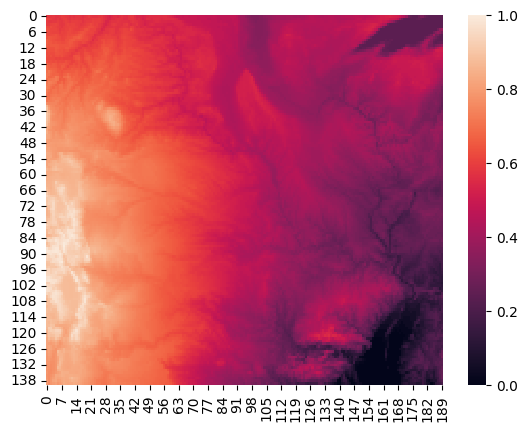

In [4]:
sns.heatmap(scaled_data)

In [5]:
class Map():
    def __init__(self, path_to_data):
        self.path_to_data = path_to_data
        self.nNAN = 0
        self.data = self._data()
        self.gradientX, self.gradientY = self._gradient()
        
    def _data(self):           
        raw_data = pd.read_csv(path_to_data, header=None).to_numpy()
        self.nNAN = sum(np.isnan(raw_data).flatten())
        raw_data = raw_data[420:560, 730:920]

        # Make sure the data doesn't have outliers
        clip_mask = raw_data < np.percentile(raw_data, 1)
        data = raw_data
        data[clip_mask] = np.percentile(raw_data, 1)

        # Squish data and scale it
        data = np.log(data)
        dMax = np.max(data)
        dMin = np.min(data)
        
        return((data - dMin) / (dMax-dMin))

    def _gradient(self):
        # Compute gradient
        return(np.gradient(self.data))

In [6]:
path_to_data = os.path.join(os.getcwd(), "data\\SRTM_RAMP2_TOPO_2000-02-11_rgb_3600x1800.CSV")
mapData = Map(path_to_data)

## Cost class

In [7]:
class Cost():
    def __init__(self, a=1, b=1, c=1, final_dist_scale=1, final_dist_weight=1):
        self.a = a
        self.b = b
        self.c = c
        self.final_dist_scale = final_dist_scale
        self.final_dist_weight = final_dist_weight
    def calculate_cost(self, gradient, distance_form_target):
        return( self.a*np.abs(gradient) + self.b + self.c*distance_form_target )
    
    def final_cost(self, current_position, final_target):
        return( self.final_dist_weight * (self.final_dist_scale * self._distance_from_ultimate_target(current_position, final_target))**2 )
    
    def _distance_from_ultimate_target(self, current_position, final_target):
        difference_vect = np.array(current_position) - np.array(final_target)
        return(np.sqrt(difference_vect.dot(difference_vect)))

## Getting the surrounding pieces

In [8]:
def get_surrounding_values(position_vect, surrounding_map):
    # Works. Grabs a 1 pixel surrounding area
    # around a given position. If hits a boundry
    # Calls those values 0.
    posX, posY = position_vect # 168, 120
    xbounds = [0,surrounding_map.shape[1]]
    ybounds = [0,surrounding_map.shape[0]]
    
    borders =  [xbounds, ybounds]
    
    leftLimit = max((posX - 1), xbounds[0])
    rightLimit = min((posX + 1) + 1, xbounds[1]) # not inclusive like the min and left limits
    lowerLimit = max((posY - 1), ybounds[0])
    upperLimit = min((posY + 1) + 1, ybounds[1]) # not inclusive like the min and left limits
     
    limits = [leftLimit, rightLimit, lowerLimit, upperLimit]    
    excision = surrounding_map[lowerLimit:upperLimit, leftLimit:rightLimit]
    into_matrix = np.zeros([3,3])
    into_matrix[(lowerLimit - (posY - 1)): (upperLimit - (posY - 1)), 
                (leftLimit - (posX - 1)): (rightLimit - (posX - 1))] = excision
    
    into_matrix = into_matrix.flatten()
    into_matrix = np.delete(into_matrix, 4)
    
    # When we have the gradient values selected, we can dot with this
    # pd.DataFrame({1: [-1, 1], 2: [0,1], 3: [1,1], 4:[1,0], 5: [1,-1], 6: [0,-1], 7:[-1,-1], 8:[-1,0]}, index = ['x','y']).T
    #      1  2  3  4  5  6  7  8
    #   x -1  0  1  1  1  0 -1 -1
    #   y  1  1  1  0 -1 -1 -1  0
    
    return(into_matrix)

def check_out_of_bounds(proposed_position, bounds):
    check1 = proposed_position[0] > 0
    check2 = proposed_position[0] < bounds[1]
    check3 = proposed_position[1] > 0
    check4 = proposed_position[1] < bounds[0]
    checks = [check1, check2, check3, check4]
    # print(checks)
    if  check1 & check2 & check3 & check4:
        return False
    else:
        # print(f'out of bounds ({proposed_position[0]},{proposed_position[1]})')
        return True

In [9]:
check_out_of_bounds([139,189], [140,190])

True

In [10]:
# 8x2 of surrounding gradients
starting_point = [0,0]
thing1 = np.concatenate( [get_surrounding_values(starting_point, mapData.gradientY)[np.newaxis,:], 
                          get_surrounding_values(starting_point, mapData.gradientX)[np.newaxis,:]], 
                        axis=0 ).T
thing1

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [-0.00292109,  0.02297167],
       [ 0.        ,  0.        ],
       [-0.00557707,  0.00288723],
       [-0.00846605,  0.        ]])

In [11]:
# 8x2
# thing2 = pd.DataFrame({1: [-1, 1], 2: [0,1], 3: [1,1], 
#                        4:[-1,0], 5: [1,0], 
#                        6: [-1,-1], 7:[0,-1], 8:[1,-1]}, index = ['x','y']).T.to_numpy()
thing2 = pd.DataFrame({1: [-1, -1], 2: [0,-1], 3: [1,-1], 
                       4:[-1,0], 5: [1,0], 
                       6: [-1,1], 7:[0,1], 8:[1,1]}, index = ['x','y']).T.to_numpy()
thing2 = thing2 / np.sqrt(np.sum(thing2*thing2, axis=1))[:,np.newaxis]

In [12]:
thing3 = np.sum(thing1*thing2, axis=1)
# mask_thing3 = thing3 <= 0
# thing3[mask_thing3] = -1
thing3

array([ 0.        ,  0.        ,  0.        ,  0.        , -0.00292109,
        0.        ,  0.00288723, -0.0059864 ])

Text(0.5, 1.0, 'Stored gradientX')

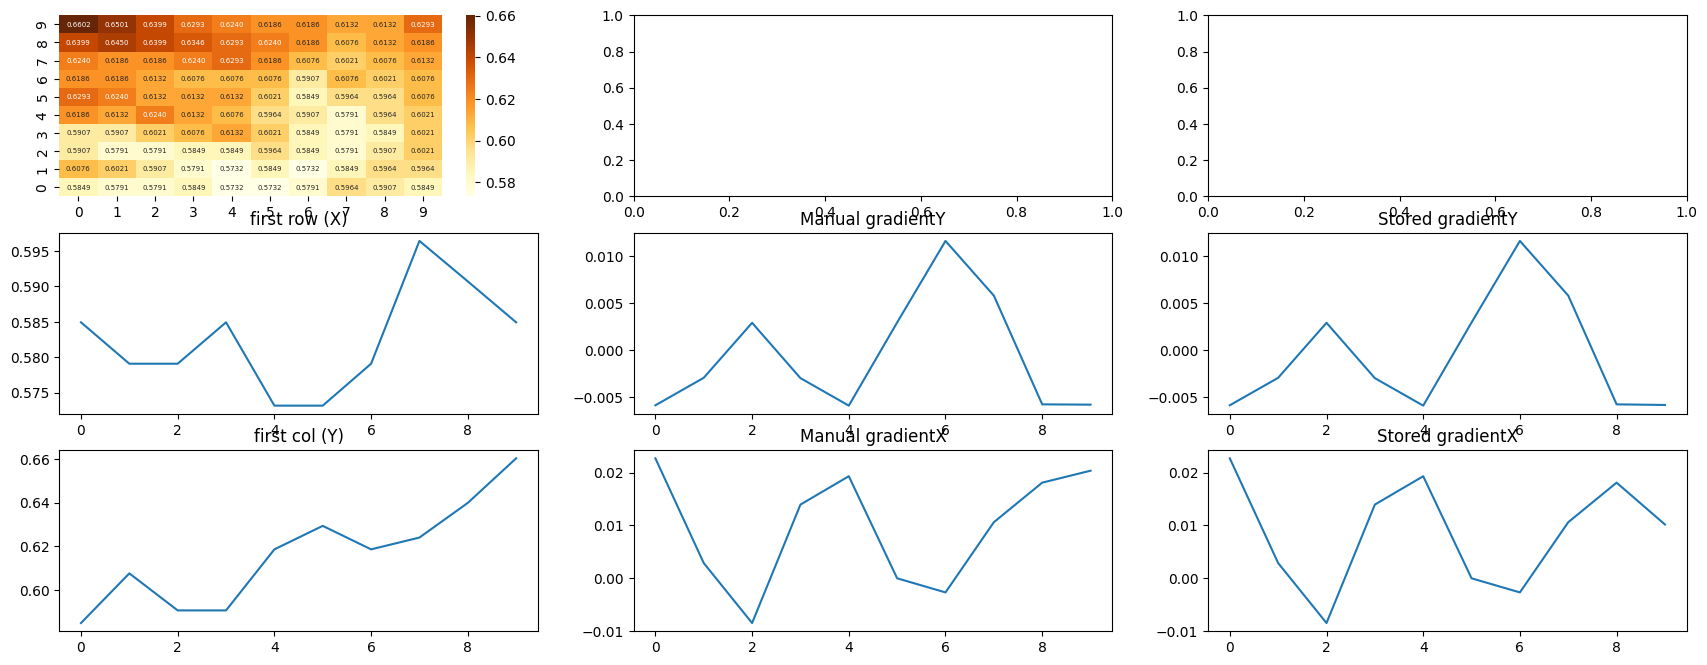

In [13]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(21,8))

sns.heatmap(mapData.data[0:10,0:10], cmap='YlOrBr', annot=True, fmt = '.4f', annot_kws = {"size": 5}, ax=axes[0,0])
axes[0,0].invert_yaxis()

axes[1,0].plot(mapData.data[0,0:10])
axes[1,0].set_title('first row (X)')
axes[1,1].plot(np.gradient(mapData.data[0,0:10]))
axes[1,1].set_title('Manual gradientY')
axes[1,2].plot(mapData.gradientY[0,0:10])
axes[1,2].set_title('Stored gradientY')

axes[2,0].plot(mapData.data[0:10,0])
axes[2,0].set_title('first col (Y)')
axes[2,1].plot(np.gradient(mapData.data[0:10,0]))
axes[2,1].set_title('Manual gradientX')
axes[2,2].plot(mapData.gradientX[0:10,0])
axes[2,2].set_title('Stored gradientX')

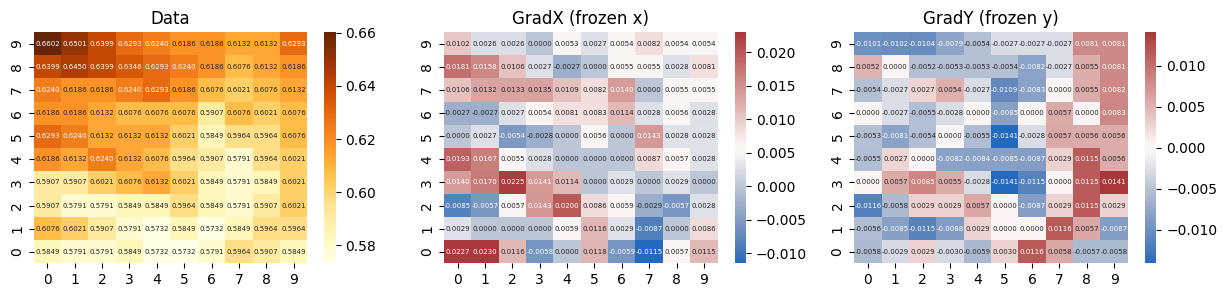

In [14]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(15,3))

sns.heatmap(mapData.data[0:10,0:10], ax = axes[0], cmap='YlOrBr', annot=True, fmt = '.4f', annot_kws = {"size": 5})
sns.heatmap(mapData.gradientX[0:10,0:10], ax = axes[1], cmap="vlag", annot=True, fmt = '.4f', annot_kws = {"size": 5})
sns.heatmap(mapData.gradientY[0:10,0:10], ax = axes[2], cmap="vlag", annot=True, fmt = '.4f', annot_kws = {"size": 5})
axes[0].set_title('Data')
axes[1].set_title('GradX (frozen x)')
axes[2].set_title('GradY (frozen y)')

for ax in axes:
    ax.invert_yaxis()

In [15]:
thing3

array([ 0.        ,  0.        ,  0.        ,  0.        , -0.00292109,
        0.        ,  0.00288723, -0.0059864 ])

### Attempt a simple path walk

In [16]:
# starting_point = np.array([10,10])
# path_walked = [starting_point]
# # 8x2 direction vectors
# thing2 = pd.DataFrame({1: [-1, 1], 2: [0,1], 3: [1,1], 
#                        4:[-1,0], 5: [1,0], 
#                        6: [-1,-1], 7:[0,-1], 8:[1,-1]}, index = ['x','y']).T.to_numpy()
# thing2_norm = thing2 / np.sqrt(np.sum(thing2*thing2, axis=1))[:,np.newaxis]

# for i in range(100):
#     thing1 = np.concatenate( [get_surrounding_values(starting_point, mapData.gradientY)[np.newaxis,:], 
#                               get_surrounding_values(starting_point, mapData.gradientX)[np.newaxis,:]], 
#                             axis=0 ).T
#     thing3 = np.sum(thing1*thing2_norm, axis=1)
#     direction = thing2[np.argmax(thing3)]
#     for i in range(2,9):
#         # If we are going back on ourselves
#         if np.any(np.all((starting_point + direction) == path_walked, axis=1)):
#             direction = thing2[np.argsort(thing3, axis=0)[-i]]
#         else:
#             break
#     starting_point = starting_point + direction
#     path_walked.append(starting_point)

# # Plotting the path
# data1 = mapData.data[0:30,0:30]
# data2 = np.array(path_walked)

# f, ax = plt.subplots(figsize=(7, 3))
# # plt.tick_params(bottom='on')
# ax = sns.heatmap(data1, cmap='YlOrBr')# , annot=True, fmt = '.4f', annot_kws = {"size": 5})

# sns.scatterplot(x=data2[:,0]+0.5, y = data2[:,1]+0.5, hue = [i for i in range(len(data2[:,0]))], linewidth=2, ax=ax, palette='viridis', legend=False, markers='.', edgecolor=None, s = 1)
# ax.axis('tight')
# ax.invert_yaxis()

# plt.show()

### Attempt at bounded walk

1991 steps taken


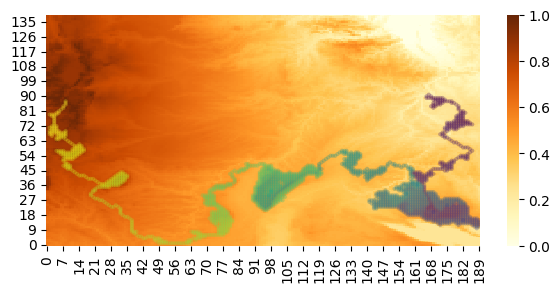

In [17]:
starting_point = np.array([168,90])# np.array([87,66]) # np.array([7,0])
path_walked = [starting_point]
# 8x2 direction vectors
thing2 = pd.DataFrame({1: [-1, -1], 2: [0,-1], 3: [1,-1], 
                       4:[-1,0], 5: [1,0], 
                       6: [-1,1], 7:[0,1], 8:[1,1]}, index = ['x','y']).T.to_numpy()
thing2_norm = thing2 / np.sqrt(np.sum(thing2*thing2, axis=1))[:,np.newaxis]

for i in range(5000):
    # print(f"iter-{i} --- {starting_point} --- {check_out_of_bounds((starting_point), mapData.data.shape)}")
    thing1 = np.concatenate( [get_surrounding_values(starting_point, mapData.gradientY)[np.newaxis,:], 
                              get_surrounding_values(starting_point, mapData.gradientX)[np.newaxis,:]], 
                            axis=0 ).T
    thing3 = np.sum(thing1*thing2_norm, axis=1)
    direction = thing2[np.argmax(thing3)]
    for j in range(2,9):
        # If we are going back on ourselves or going out of bounds
        # try a different direction
        if np.any(np.all((starting_point + direction) == path_walked, axis=1)) | check_out_of_bounds((starting_point + direction), mapData.data.shape):
            direction = thing2[np.argsort(thing3, axis=0)[-j]]
        else:
            break
    starting_point = starting_point + direction
    path_walked.append(starting_point)
    if mapData.data[starting_point[1], starting_point[0]] == np.max(mapData.data):
        print(f'{i} steps taken')
        break

# Plotting the path
data1 = mapData.data[0:200,0:200]
data2 = np.array(path_walked)

f, ax = plt.subplots(figsize=(7, 3))
# plt.tick_params(bottom='on')
ax = sns.heatmap(data1, cmap='YlOrBr')# , annot=True, fmt = '.4f', annot_kws = {"size": 5})

sns.scatterplot(x=data2[:,0]+0.5, y = data2[:,1]+0.5, hue = [i for i in range(len(data2[:,0]))], linewidth=2, ax=ax, palette='viridis', legend=False, markers='.', edgecolor=None, s = 1, alpha = 0.3)
ax.axis('tight')
ax.invert_yaxis()

plt.show()

## Making the neural net
- We need a layer class that can perform the forward pass
- We need an activation function (ReLu) each node can experience
- We need the final output layer and the softmax activation function
- Ultimately we need a method to return trainable weights that we can choose from and edit
- We need a way to randomly initiate all trainable weights

### Layer class

In [18]:
# Improved below
# class Layer():
#     def __init__(self, nNodes, nInput, AF):
#         self.nNodes = nNodes
#         self.nInput = nInput
#         self.AF = AF # Instance of the activation function class
#         self.A = np.random.normal(size=[self.nNodes,self.nInput])
#         self.offset = np.random.normal(size = self.nNodes)
    
#     def forward(self, fInput):
#         Input = np.reshape(fInput, (self.nInput, -1))
#         vec = np.matmul(self.A, fInput) + self.offset
#         return(np.array([self.AF.activate(i) for i in vec]))
    
#     def return_weights(self):
#         return(self.A)
#     def return_offset(self):
#         return(self.offset)
#     def update_weights(self,B):
#         self.A = B    
#     def update_offset(self,new_offset):
#         self.offset = new_offset
        
#     def __str__(self):
#         return( f"Layer class ({self.nNodes},{self.nInput})" )

class ActivationFunc():
    def __init__(self):
        self.typeOfActivator = 'general'
    
    def activate(self, i):
        return( i )
        
    
class ReLu_ActivationFunc(ActivationFunc):
    def __init__(self):
        self.typeOfActivator = 'ReLu'
    
    def activate(self, i):
        return( np.max([0, i]) )

In [19]:
class Layer():
    def __init__(self, nNodes, nInput, AF, normalize=False):
        self.nNodes = nNodes
        self.nInput = nInput
        self.AF = AF # Instance of the activation function class
        self.A = np.random.normal(size=[self.nNodes,self.nInput])
        self.offset = np.random.normal(size = self.nNodes)
        self.normalize = normalize
    
    def forward(self, fInput):
        fInput = np.array(fInput)
        if self.normalize:
            fInput = (fInput - np.min(fInput)) / (np.max(fInput) - np.min(fInput))
            fInput = np.log(fInput + 0.0001)
        Input = np.reshape(fInput, (self.nInput, -1))
        vec = np.matmul(self.A, fInput) + self.offset
        return( np.array([self.AF.activate(i) for i in vec]) )
    
    def return_just_weights(self):
        return(self.A)
    def return_just_offset(self):
        return(self.offset)
    def update_just_weights(self,B):
        self.A = B    
    def update_just_offset(self,new_offset):
        self.offset = new_offset
    def return_weights(self):
        return(np.concatenate([self.A, self.offset[:,np.newaxis]], axis = 1))
    def update_weights(self, B):
        B = np.array(B)
        self.A = B[:,:-1]
        self.offset = B[:,-1]
        
    def __str__(self):
        return( f"Layer class ({self.nNodes},{self.nInput})" )

In [20]:
class Normalization_Layer():
    def __init__(self):
        pass
    
    def forward(self, fInput):
        return( (fInput - np.min(fInput)) / ((np.max(fInput)) - (np.min(fInput))) )
    
    def return_just_weights(self):
        return(None)
    def return_just_offset(self):
        return(None)
    def update_just_weights(self,B):
        pass    
    def update_just_offset(self,new_offset):
        pass
    def return_weights(self):
        return(None)
    def update_weights(self, B):
        pass

In [21]:
raw_AF = ActivationFunc()
relu = ReLu_ActivationFunc()
layer1 = Layer(3, 8, relu)

In [22]:
layer1.forward([1,2,3,4,5,6,7,8])

array([0., 0., 0.])

In [23]:
net = [Layer(3,3,relu) for i in range(3)]
net = [Layer(3,8,relu)] + net + [Layer(8, 3, raw_AF)]
input_values = [1,2,3,4,5,6,7,8]
for i in range(len(net)-1):
    input_values = net[i].forward(input_values)
output_values = net[-1].forward(input_values)
output_values

array([ 1.94079129, -2.06731377,  0.24953787, -6.13080708,  1.2387153 ,
        0.02843024,  0.3889835 ,  2.91923071])

In [24]:
display(net[0].return_weights())

array([[-0.05770821, -0.83550746,  2.03150116,  1.20203992,  0.69496961,
         0.09325547, -1.16725801,  1.25682889, -1.11442886],
       [ 1.1302511 , -0.4196629 , -1.58374871, -1.74084108,  2.81427118,
         0.21052299, -0.35528196,  0.66435038,  1.79951941],
       [-0.1610186 ,  0.04253674, -0.58831709, -1.204068  , -0.03581929,
         0.29403311,  1.52031852,  0.37223473, -0.2816541 ]])

### Brain class

In [25]:
class Brain():
    def __init__(self, nLayers, nNodes, nInput, nOutput, hidden_AF, output_AF):
        self.nLayers = nLayers
        self.nNodes = nNodes
        self.nInput = nInput
        self.nOutput = nOutput
        self.net = [Layer(nNodes,nNodes,hidden_AF) for i in range(nLayers)]
        self.net = [Layer(nNodes,nInput,hidden_AF,normalize=True)] + self.net + [Layer(nOutput, nNodes, output_AF)]
        self.weights_linear = np.concatenate([i.return_weights().flatten() for i in self.net],axis=0)
        self.weights_shape = [i.return_weights().shape for i in self.net]
        self.expected_input_shape = nInput
        
    def forward_pass(self, input_values):
        # Loop through all layers except last one
        for i in range(len(self.net)-1):
            input_values = self.net[i].forward(input_values)
        # Return the output of the last layer
        return( self.net[-1].forward(input_values) )
    
    def mutate_random(self, mutation_rate = 0.05, mutation_aggressiveness = 0.2):
        index = np.random.choice([i for i in range(len(self.weights_linear))], size = int(len(self.weights_linear)*mutation_rate), replace = False)
        mutations = np.random.normal(scale = mutation_aggressiveness, size = len(index))
        self.weights_linear[index] += mutations
        self._update_weights()
        
    def mutate_cross_breeding(self, other_brain, parental_dominance = 0.5):
        index = np.random.choice([False,True], size = len(self.weights_linear), replace = True, p = [parental_dominance, 1-parental_dominance])
        self.weights_linear[index] = other_brain.weights_linear[index]
        self._update_weights()
        
    def _update_weights(self):
        previous_end = 0
        # Loop over layers
        for i in range(len(self.weights_shape)):
            new_end = previous_end + self.weights_shape[i][0]*self.weights_shape[i][1]
            new_weight = np.reshape(self.weights_linear[previous_end:new_end], self.weights_shape[i])
            self.net[i].update_weights(new_weight)
            previous_end = new_end
            
    def get_weights(self):
        return([i.return_weights() for i in self.net])
        
    

In [26]:
raw_AF = ActivationFunc()
relu = ReLu_ActivationFunc()
Brain1 = Brain(3, 3, 8, 8, relu, raw_AF)
Brain2 = Brain(3, 3, 8, 8, relu, raw_AF)

In [27]:
Brain1.forward_pass([1,1,1,1,1,1,1,1])

C:\Users\mattk\miniconda3\envs\ops\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


array([nan, nan, nan, nan, nan, nan, nan, nan])

In [28]:
Brain1.mutate_random()
Brain1.forward_pass([1,1,1,1,1,1,1,1])

C:\Users\mattk\miniconda3\envs\ops\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


array([nan, nan, nan, nan, nan, nan, nan, nan])

In [29]:
Brain2 = Brain(3, 3, 8, 8, relu, raw_AF)
Brain3 = Brain(3,3,8,8,relu,raw_AF)

In [30]:
display(Brain2.net[0].return_weights())
display(Brain3.net[0].return_weights())

array([[ 1.53563089,  0.41513139,  0.33184913,  0.59048232,  0.92291014,
        -0.61150456, -0.99262655,  0.67228002, -0.9837683 ],
       [ 0.55341367,  2.43591549,  1.25330359, -0.23810825, -1.12588712,
        -0.9799177 , -0.42505843, -0.03021547, -2.32441729],
       [ 1.46369095,  0.1749381 ,  0.55651612, -0.68936085, -0.43751082,
         1.09512228,  2.00452516,  0.11692223, -2.42268644]])

array([[-0.08721634,  2.25394111, -0.31102301,  1.77806344,  0.84017713,
         0.71019902,  0.11698767,  1.64066742, -0.15200493],
       [-0.19507408,  1.35094336, -0.08172462, -1.54278386,  0.38774888,
         0.50847439,  1.17588075,  2.15800705,  1.58866055],
       [ 0.08130745,  2.60475671,  1.69173836,  0.72122796,  1.51979534,
        -0.23846935,  1.42336788, -2.32525922, -0.11519936]])

In [31]:
Brain2.mutate_cross_breeding(Brain3)
Brain2.net[0].return_weights()

array([[ 1.53563089,  2.25394111, -0.31102301,  0.59048232,  0.92291014,
        -0.61150456, -0.99262655,  0.67228002, -0.9837683 ],
       [-0.19507408,  2.43591549, -0.08172462, -0.23810825, -1.12588712,
         0.50847439,  1.17588075, -0.03021547, -2.32441729],
       [ 1.46369095,  2.60475671,  0.55651612,  0.72122796,  1.51979534,
        -0.23846935,  1.42336788,  0.11692223, -2.42268644]])

### Beast class

In [72]:
class Beast():
    def __init__(self, Brain, Map, Cost, 
                 start_point, target_height, ultimate_target_coordinates, 
                 max_step=5000, reached_checkpoint_reward=-20, out_of_bounds_penalty = 2000):
        self.Brain = Brain
        self.Map = Map
        self.Cost = Cost
        self.max_step = max_step
        self.start_point = np.array(start_point)
        self.target_height = target_height
        self.ultimate_target_coordinates = ultimate_target_coordinates
        self.nSteps = 0
        self.current_height = self.Map.data[self.start_point[1], self.start_point[0]]
        self.path_taken = [self.start_point]
        self.current_position = [self.start_point[1], self.start_point[0], self.current_height]
        self.accumulated_cost = 0
        self.costs_along_path = [0]
        self.reached_checkpoint = False
        self.reached_checkpoint_reward = reached_checkpoint_reward
        self.out_of_bounds = False
        self.out_of_bounds_penalty = out_of_bounds_penalty
        # surrounding_box_directions_matrix used for
        # directional gradient calculations
        self.sbdm = pd.DataFrame({1: [-1, -1], 2: [0,-1], 3: [1,-1], 
                                  4:[-1,0], 5: [1,0], 6: [-1,1], 
                                  7:[0,1], 8:[1,1]}, index = ['x','y']).T.to_numpy()
        self.sbdm_norm = self.sbdm / np.sqrt(np.sum(self.sbdm*self.sbdm, axis=1))[:,np.newaxis]
        
    def play_simulation(self):
        starting_point = self.start_point
        for i in range(self.max_step):
            gradient_matrix = np.concatenate( [self._get_surrounding_values(starting_point, self.Map.gradientY)[np.newaxis,:],
                                               self._get_surrounding_values(starting_point, self.Map.gradientX)[np.newaxis,:]],
                                             axis=0 ).T
            directional_gradients = np.sum(gradient_matrix*self.sbdm_norm, axis=1)
            # print(np.concatenate([np.array(directional_gradients), np.array(starting_point)], axis=0))
            # break
            decision_vector = self.Brain.forward_pass(np.concatenate([np.array(directional_gradients), np.array(starting_point)], axis=0))
            direction = self.sbdm[np.argmax(decision_vector)]
            if self._check_out_of_bounds((starting_point + direction), self.Map.data.shape):
                self.out_of_bounds = True
                self.accumulated_cost += self.out_of_bounds_penalty
                self.costs_along_path.append(self.out_of_bounds_penalty)
                break
            else:
                pass
            starting_point = starting_point + direction
            self.nSteps += 1
            self.path_taken.append(starting_point)
            self.current_height = self.Map.data[starting_point[1], starting_point[0]]
            self.current_position = [starting_point[0], starting_point[1], self.current_height]
            self._calc_cost(directional_gradients[np.argmax(decision_vector)])

            if self.current_height >= self.target_height:
                self.reached_checkpoint = True
                self.accumulated_cost += self.reached_checkpoint_reward
                self.costs_along_path.append(self.reached_checkpoint_reward)
                break
            else:
                pass
            
        self.accumulated_cost += self.Cost.final_cost(self.path_taken[-1], self.ultimate_target_coordinates)
        self.costs_along_path.append( self.Cost.final_cost(self.path_taken[-1], self.ultimate_target_coordinates) )
        
    def breed_with(self, otherBeast):
        self.Brain.mutate_cross_breeding(otherBeast.Brain)
    def random_mutation(self):
        self.Brain.mutate_random()
    def _get_surrounding_values(self, position_vect, surrounding_map):
        # Works. Grabs a 1 pixel surrounding area
        # around a given position. If hits a boundry
        # Calls those values 0.
        posX, posY = position_vect # 168, 120
        xbounds = [0,surrounding_map.shape[1]]
        ybounds = [0,surrounding_map.shape[0]]

        leftLimit = max((posX - 1), xbounds[0])
        rightLimit = min((posX + 1) + 1, xbounds[1]) # not inclusive like the min and left limits
        lowerLimit = max((posY - 1), ybounds[0])
        upperLimit = min((posY + 1) + 1, ybounds[1]) # not inclusive like the min and left limits

        excision = surrounding_map[lowerLimit:upperLimit, leftLimit:rightLimit]
        into_matrix = np.zeros([3,3])
        into_matrix[(lowerLimit - (posY - 1)): (upperLimit - (posY - 1)), 
                    (leftLimit - (posX - 1)): (rightLimit - (posX - 1))] = excision

        into_matrix = into_matrix.flatten()
        into_matrix = np.delete(into_matrix, 4)
        return(into_matrix)
    def _check_out_of_bounds(self, proposed_position, bounds):
        # Returns False if in bounds, true otherwise
        check1 = proposed_position[0] > 0
        check2 = proposed_position[0] < bounds[1]
        check3 = proposed_position[1] > 0
        check4 = proposed_position[1] < bounds[0]
        checks = [check1, check2, check3, check4]
        if  check1 & check2 & check3 & check4:
            return False
        else:
            return True
    def _calc_cost(self, gradient_of_step):
        step_cost = self.Cost.calculate_cost(gradient_of_step, np.abs(self.target_height - self.current_height))
        self.accumulated_cost += step_cost
        self.costs_along_path.append(step_cost)
    def get_distance_from_ultimate_target(self):
        difference_vect = np.array(self.path_taken[-1]) - np.array(self.ultimate_target_coordinates)
        return(np.sqrt(difference_vect.dot(difference_vect)))

In [33]:
Map1 = Map(path_to_data)

In [34]:
raw_AF = ActivationFunc()
relu = ReLu_ActivationFunc()
# Cost1 = Cost(a = 50, final_dist_scale=1/15)
Cost1 = Cost(a = 70, final_dist_scale=1/15, final_dist_weight=0.8)
target_index = np.unravel_index(np.argmax(Map1.data, axis=None), Map1.data.shape)[::-1]

In [56]:
Beast_stats = []
for i in range(1000):
    Beast_brain = Brain(2,5,10,8,relu,raw_AF)
    Beast_spawn = Beast(Beast_brain, Map1, Cost1, start_point = [146,26], target_height = 0.87, ultimate_target_coordinates = target_index, max_step=20)
    Beast_spawn.play_simulation()
    Beast_stats.append([Beast_spawn.accumulated_cost, Beast_spawn.nSteps, Beast_spawn])
pd.DataFrame(np.unique(np.array(Beast_stats)[:,0], return_counts=True))

,0,1,2,3,4,5,6,7,8,9,...,98,99,100,101,102,103,104,105,106,107
0,94.925634,95.723023,97.962709,100.53462,101.039665,102.742484,103.830967,104.219605,104.997873,106.658999,...,153.783979,155.665584,155.895856,157.143294,157.219751,158.512595,158.731349,159.440171,163.638489,175.61802
1,110.000000,1.000000,1.000000,1.00000,110.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,122.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [57]:
display([f"{i}: {beast[0]}" for i, beast in enumerate(Beast_stats)])
np.argmin(np.array(Beast_stats)[:,0])

['0: 101.03966472287249',
 '1: 101.03966472287249',
 '2: 144.6338042539879',
 '3: 115.25859384593713',
 '4: 101.03966472287249',
 '5: 141.13422840089314',
 '6: 144.6338042539879',
 '7: 141.13422840089314',
 '8: 141.13422840089314',
 '9: 114.13622289275828',
 '10: 141.13422840089314',
 '11: 142.71503368388306',
 '12: 141.13422840089314',
 '13: 157.21975083752358',
 '14: 101.03966472287249',
 '15: 101.03966472287249',
 '16: 115.25859384593713',
 '17: 157.21975083752358',
 '18: 101.03966472287249',
 '19: 145.46204797784324',
 '20: 114.13622289275828',
 '21: 146.3852409983957',
 '22: 115.25859384593713',
 '23: 140.9165287423333',
 '24: 138.36628948167987',
 '25: 157.21975083752358',
 '26: 94.92563377592523',
 '27: 101.03966472287249',
 '28: 141.23068246158175',
 '29: 101.03966472287249',
 '30: 115.25859384593713',
 '31: 115.25859384593713',
 '32: 141.13422840089314',
 '33: 157.21975083752358',
 '34: 141.13422840089314',
 '35: 144.6338042539879',
 '36: 141.13422840089314',
 '37: 132.4411780

26

Cost: 95.72302314261867
Dist: 125.86500705120545


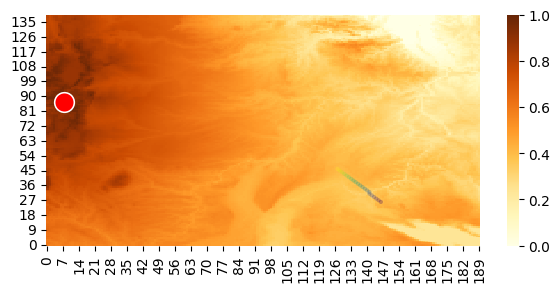

In [58]:
#Brain1 = Brain(3, 5, 10, 8, relu, raw_AF)
#Beast1 = Beast(Brain1, Map1, Cost1, start_point = [146,26], target_height = 0.99, ultimate_target_coordinates = target_index, max_step=50)
#Beast1.play_simulation()
Beast1 = Beast_stats[223]
Beast1 = Beast1[2]

print(f"Cost: {Beast1.accumulated_cost}\nDist: {Beast1.get_distance_from_ultimate_target()}")
# Plotting the path
data1 = mapData.data[0:200,0:200]
data2 = np.array(Beast1.path_taken)

f, ax = plt.subplots(figsize=(7, 3))
# plt.tick_params(bottom='on')
ax = sns.heatmap(data1, cmap='YlOrBr')# , annot=True, fmt = '.4f', annot_kws = {"size": 5})

sns.scatterplot(x=data2[:,0]+0.5, y = data2[:,1]+0.5, hue = [i for i in range(len(data2[:,0]))], linewidth=2, ax=ax, palette='viridis', legend=False, markers='.', edgecolor=None, s = 1, alpha = 0.3)
sns.scatterplot(x=[target_index[0]], y=[target_index[1]], color='red', s=200)
ax.axis('tight')
ax.invert_yaxis()

plt.show()

In [38]:
Beast_stats[0][2].Brain.get_weights()

[array([[ 0.36569759,  1.52759877, -0.75069451, -0.19820763, -1.25730353,
          1.18277996, -0.40130797,  1.70790791, -0.47157573, -0.68012393,
         -1.10238795],
        [-2.36507064,  1.92921101,  0.36002886,  0.24537091, -0.75468592,
          0.19127423, -0.66265812, -0.29160775, -1.726098  , -0.3092933 ,
          1.4164086 ],
        [ 0.24959728,  0.50151444,  1.88181671,  0.38926109, -0.53938202,
         -0.83869331, -0.3209072 , -1.14588276, -1.15525833,  1.74082927,
         -0.63719636],
        [ 0.60005239, -0.13379437,  1.4293209 , -0.49593591, -1.02701046,
          0.75907989,  0.91938548,  1.9609913 , -1.41582126, -0.03912693,
         -0.38165065],
        [ 1.13803454,  0.97609119, -0.2222424 ,  1.00583072,  2.11980617,
          0.42020762,  0.702238  ,  0.60473494,  0.66687067,  1.52580564,
          0.28095507]]),
 array([[ 0.58077845, -0.81439881, -0.39702737,  0.09587731,  1.37100108,
          0.25637967],
        [-1.01924919,  0.9589504 , -1.05652255

## Beast handler class

### Beast reproduction dynamics
Criteria: I want the best performing beasts to reproduce the most, and the reproduction success to taper off as performance falters. For this I decided that the exponential distribtuion will do well

Top 100 beast reproduction: [7. 7. 7. 6. 6. 5. 5. 5. 4. 4. 4. 4. 4. 3. 3. 3. 3. 3. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


724.2615242193868

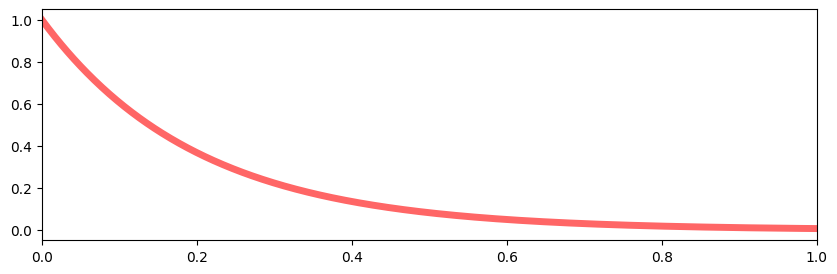

In [39]:
plt.figure(figsize=(10,3))
plt.xlim([0,1])
scale = 0.2
x = np.linspace(expon.ppf(0.001, scale=scale),
                expon.ppf(0.999, scale=scale), 1000)
y = np.array(expon.pdf(x, scale=scale))
print(f"Top 100 beast reproduction: {np.ceil(y[0:1000:10]/sum(y) * len(y))}")
plt.plot(x, y/np.max(y),
       'r-', lw=5, alpha=0.6, label='expon pdf')
display(sum(y))

Top 100 beast reproduction: [5. 4. 4. 4. 4. 4. 4. 4. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


245.6851545625716

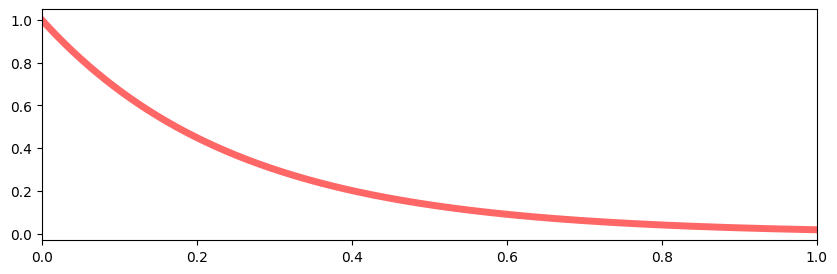

In [40]:
plt.figure(figsize=(10,3))
plt.xlim([0,1])

def expDist(x, a=1, b=4):
    return(a*np.exp(-b*x))

x = np.linspace(0,1,1000)
y = expDist(x)
print(f"Top 100 beast reproduction: {np.ceil(y[0:1000:10]/sum(y) * len(y))}")
plt.plot(x, y/np.max(y),
       'r-', lw=5, alpha=0.6, label='expon pdf')
display(sum(y))

In [41]:
# Input nslots, expDist
# Output array of children to spawn for each position
slots = 50
ybar=quad(expDist, 0, 1)[0]
positionalY = []
for i in range(slots):
    positionalY.append(quad(expDist, i/slots, (i+1)/slots)[0])
positionalY = np.ceil(np.array(positionalY)/ybar * slots)

summation = 0
fixedPositionalY = []
for i in positionalY:
    summation += i
    if summation > slots:
        fixedPositionalY.append(int(0))
    else:
        fixedPositionalY.append(int(i))
fixedPositionalY
sum(fixedPositionalY)

50

### Coding the handler class

In [152]:
class Beast_Handler():
    def __init__(self, Cost_instance, Map_instance, Brain_class, Beast_class, raw_AF, relu, reproduce_distribution=expon,
                 start_point=[146,26], target_height=1, ultimate_target_coordinates = [8,87], max_step = 80,  
                 ncycles_evol=100, nbeasts_per_cycle=100, percent_top_keep=50, 
                 random_mutation_rate=0.1):
        self.max_step = max_step
        self.ultimate_target_coordinates = ultimate_target_coordinates
        self.target_height = target_height
        self.start_point = start_point
        self.Cost_instance = Cost_instance
        self.Map_instance = Map_instance
        self.Brain_class = Brain_class
        self.Beast_class = Beast_class
        self.raw_AF = raw_AF
        self.relu = relu
        self.ncycles_evol = ncycles_evol
        self.nbeasts_per_cycle = nbeasts_per_cycle
        self.percent_top_keep = percent_top_keep / 100
        self.reproduce_distribution = reproduce_distribution
        self.random_mutation_rate = random_mutation_rate
        self.Beast_collection = self._make_beasts()
        self.best_beast = []
        self.children_per_position = self._children_per_position(slots = self.nbeasts_per_cycle - int(self.nbeasts_per_cycle*self.percent_top_keep))
        
    def _children_per_position(self, slots):
        # Input nslots, expDist
        # Output array of children to spawn for each position
        ybar=quad(expDist, 0, 1)[0]
        positionalY = []
        for i in range(slots):
            positionalY.append(quad(self.reproduce_distribution, i/slots, (i+1)/slots)[0])
        positionalY = np.ceil(np.array(positionalY)/ybar * slots)

        summation = 0
        fixedPositionalY = []
        for i in positionalY:
            summation += i
            if summation > slots:
                fixedPositionalY.append(int(0))
            else:
                fixedPositionalY.append(int(i))
        return(fixedPositionalY)

    def _reproduce_beasts(self, array_of_beasts):
        array_to_return = []
        for Beast, children in zip(array_of_beasts, self.children_per_position):
            for i in range(children):
                array_to_return.append(Beast)
        return(self._copy_beasts(array_to_return, breed=True))
        
    def _make_beasts(self):
        """Returns an array of beasts with their own unique brains"""
        Beast_stats = []
        for i in range(self.nbeasts_per_cycle):
            #                   nHiddenLayer, nNodes
            Beast_brain = self.Brain_class(2,5,10,8,self.relu,self.raw_AF)
            Beast_spawn = Beast(Beast_brain, self.Map_instance, self.Cost_instance, start_point = self.start_point, target_height = self.target_height, ultimate_target_coordinates = self.ultimate_target_coordinates, max_step=self.max_step)
            Beast_stats.append(Beast_spawn)
        return(np.array(Beast_stats))
            
    def _make_beasts_random(self, array_of_beasts):
        """Given the array of beasts, it will mutate them and return it right back"""
        array_of_beasts = np.array(array_of_beasts)
        index = np.random.choice([True, False], size = len(array_of_beasts), replace = True, p = [self.random_mutation_rate, 1-self.random_mutation_rate])
        [Beast.random_mutation() for Beast in array_of_beasts[index]]
        return( array_of_beasts )
            
    def _copy_beasts(self, array_of_beasts, breed=False):
        """Given an array of beasts, make a deep copy of their brains. If breed=T returned beasts will be mix and matched"""
        array_of_beasts = np.array(array_of_beasts)
        Beast_copys = []
        for i in range(len(array_of_beasts)):
            Beast_brain = copy.deepcopy(array_of_beasts[i].Brain)
            if breed:
                index = np.random.choice(len(array_of_beasts), size=1)
                Beast_brain.mutate_cross_breeding(array_of_beasts[index][0].Brain)
            Beast_spawn = Beast(Beast_brain, self.Map_instance, self.Cost_instance, start_point = self.start_point, target_height = self.target_height, ultimate_target_coordinates = self.ultimate_target_coordinates, max_step=self.max_step)
            Beast_copys.append(Beast_spawn)
        return(np.array(Beast_copys))
    
    def play_simulation(self):
        """"When called this will loop through the cycles of evolution and run the simulation. Capable of mutating each round and returns final cohort"""
        for cycle in range(self.ncycles_evol):
            # Run simulation
            print(f"\rCycle: {cycle}", end='', flush=True)
            Beast_stats = []
            for Beast_spawn in self.Beast_collection:
                Beast_spawn.play_simulation()
                Beast_stats.append([Beast_spawn.accumulated_cost, Beast_spawn])
            # Sort
            Beast_stats = sorted(Beast_stats, key=lambda Beast: Beast[0]) 
            self.best_beast.append(Beast_stats[0][1])
            # print(Beast_stats)
            # print(self.best_beast)
            # Kill
            Beasts_to_keep = self._copy_beasts( np.array(Beast_stats)[0:int(self.nbeasts_per_cycle*self.percent_top_keep),1] )
            # print(Beasts_to_keep)
            # Reproduce
            Beasts_reproduced = self._reproduce_beasts(Beasts_to_keep)
            # print(Beasts_reproduced)
            # Mutate
            Beasts_reproduced = self._make_beasts_random(Beasts_reproduced)
            Beasts = np.concatenate([Beasts_to_keep, Beasts_reproduced], axis=0)      
            # print(Beasts_reproduced, "\n===============================================\n\n")
            
            self.Beast_collection = Beasts

In [129]:
raw_AF = ActivationFunc()
relu = ReLu_ActivationFunc()
Cost1 = Cost(a = 60, final_dist_scale=1/15, final_dist_weight=0.8) # works good for the not deep area Cost(a = 100, final_dist_scale=1/15, final_dist_weight=0.6)
target_index = np.unravel_index(np.argmax(Map1.data, axis=None), Map1.data.shape)[::-1]

In [153]:
# Cost_instance, Map_instance, Brain_class, Beast_class, raw_AF, relu,
Beast_collection = Beast_Handler(Cost1, Map1, Brain, Beast, raw_AF, relu, 
                                 reproduce_distribution=expDist, random_mutation_rate=0.1, max_step = 50, 
                                 ncycles_evol=25, nbeasts_per_cycle=1000, start_point=[26,57])

#### Testing the _copy_beasts function()

In [45]:
old_beasts = Beast_collection.Beast_collection[0:10]
old_beasts[0].nSteps = 100
new_beasts = Beast_collection._copy_beasts(old_beasts, breed = True)

In [46]:
# Hoping to see that the brain is the same but nSteps are different
display(old_beasts[0].Brain.get_weights())
old_beasts[0].nSteps

[array([[ 1.94710139, -0.87687499,  1.56141729, -1.20794249,  0.41898064,
          1.48188242,  1.24556989, -1.23547214,  0.03532018, -0.79312005,
          0.12673288],
        [ 0.89310789,  1.0863915 , -0.47004949, -0.26242483,  0.46548078,
         -1.30790741,  0.18200201,  1.14524309,  1.11848788, -0.13945931,
          0.58936142],
        [ 0.38319822,  2.59392172, -1.25825447, -1.11390031, -0.16174515,
          2.00306814, -1.40615309,  0.68856461,  0.3810687 , -1.44093116,
          1.24527212]]),
 array([[-0.71353358,  0.3810105 ,  0.87362355,  0.43663488],
        [ 2.31898438,  0.65667604, -1.42661633, -0.13377698],
        [-1.57268144, -0.24510387, -0.47904184, -1.43749863]]),
 array([[-0.166857  ,  0.50046659, -0.18491332, -0.32853047],
        [ 0.24492047,  0.70264298, -0.22812917, -0.61228504],
        [ 0.03658379, -1.54395412,  1.435585  ,  0.45000969]]),
 array([[-0.62318568,  0.74313267, -0.99028932,  0.50009576],
        [-0.37683684,  0.92851593,  1.66931878,

100

In [47]:
display(new_beasts[0].nSteps)
new_beasts[0].Brain.get_weights()

0

[array([[ 1.94710139, -0.87687499,  1.56141729, -1.20794249,  0.41898064,
          1.48188242,  1.24556989, -1.23547214,  0.03532018, -0.79312005,
          0.12673288],
        [ 0.89310789,  1.0863915 , -0.47004949, -0.26242483,  0.46548078,
         -1.30790741,  0.18200201,  1.14524309,  1.11848788, -0.13945931,
          0.58936142],
        [ 0.38319822,  2.59392172, -1.25825447, -1.11390031, -0.16174515,
          2.00306814, -1.40615309,  0.68856461,  0.3810687 , -1.44093116,
          1.24527212]]),
 array([[-0.71353358,  0.3810105 ,  0.87362355,  0.43663488],
        [ 2.31898438,  0.65667604, -1.42661633, -0.13377698],
        [-1.57268144, -0.24510387, -0.47904184, -1.43749863]]),
 array([[-0.166857  ,  0.50046659, -0.18491332, -0.32853047],
        [ 0.24492047,  0.70264298, -0.22812917, -0.61228504],
        [ 0.03658379, -1.54395412,  1.435585  ,  0.45000969]]),
 array([[-0.62318568,  0.74313267, -0.99028932,  0.50009576],
        [-0.37683684,  0.92851593,  1.66931878,

#### Testing the _make_beasts_random() function

In [48]:
old_beasts = Beast_collection.Beast_collection[0:10]
new_beasts = Beast_collection._copy_beasts( old_beasts )
new_beasts = Beast_collection._make_beasts_random( new_beasts )

In [49]:
n = 0
display(old_beasts[n].Brain.forward_pass([1,1,1,1,1,1,1,1,1,0]))
new_beasts[n].Brain.forward_pass([1,1,1,1,1,1,1,1,1,0])

array([-0.91914954, -4.20015817,  1.0142644 ,  0.05179705, -6.72287034,
       -3.56248383,  4.62635435,  1.16131936])

array([-0.91914954, -4.20015817,  1.0142644 ,  0.05179705, -6.72287034,
       -3.56248383,  4.62635435,  1.16131936])

#### Testing _children_per_position(self, slots) function

In [50]:
Beast_collection._children_per_position(50)

[4,
 4,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

#### Testing play_simulation() function

In [154]:
Beast_collection.play_simulation()

Cycle: 24

In [155]:
[[i,Beast.accumulated_cost] for i,Beast in enumerate(Beast_collection.best_beast)]

[[0, 50.28291444851864],
 [1, 50.28291444851864],
 [2, 50.28291444851864],
 [3, 50.28291444851864],
 [4, 37.921849221998194],
 [5, 37.921849221998194],
 [6, 37.921849221998194],
 [7, 37.921849221998194],
 [8, 37.921849221998194],
 [9, 37.921849221998194],
 [10, 33.92326242091604],
 [11, 33.92326242091604],
 [12, 33.92326242091604],
 [13, 33.92326242091604],
 [14, 33.92326242091604],
 [15, 33.92326242091604],
 [16, 33.044411024979624],
 [17, 33.044411024979624],
 [18, 33.044411024979624],
 [19, 33.044411024979624],
 [20, 33.044411024979624],
 [21, 33.044411024979624],
 [22, 33.044411024979624],
 [23, 32.34303958803797],
 [24, 32.34303958803797]]

Cost: 33.92326242091604
Dist: 0.0


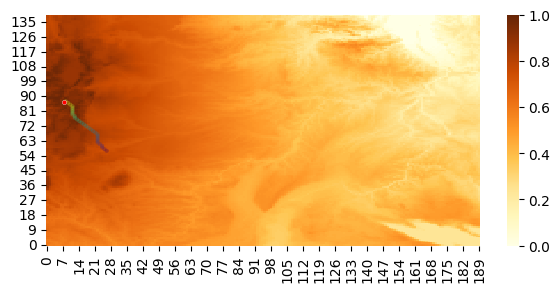

In [161]:
#Brain1 = Brain(3, 5, 10, 8, relu, raw_AF)
#Beast1 = Beast(Brain1, Map1, Cost1, start_point = [146,26], target_height = 0.99, ultimate_target_coordinates = target_index, max_step=50)
#Beast1.play_simulation()
Beast1 = Beast_collection.best_beast[10]

print(f"Cost: {Beast1.accumulated_cost}\nDist: {Beast1.get_distance_from_ultimate_target()}")
# Plotting the path
data1 = mapData.data[0:200,0:200]
data2 = np.array(Beast1.path_taken) # total_path_taken #

f, ax = plt.subplots(figsize=(7, 3))
# plt.tick_params(bottom='on')
ax = sns.heatmap(data1, cmap='YlOrBr')# , annot=True, fmt = '.4f', annot_kws = {"size": 5})

sns.scatterplot(x=data2[:,0]+0.5, y = data2[:,1]+0.5, hue = [i for i in range(len(data2[:,0]))], linewidth=2, ax=ax, palette='viridis', legend=False, markers='.', edgecolor=None, s = 1, alpha = 0.3)
sns.scatterplot(x=[target_index[0]], y=[target_index[1]], color='red', s=10)
ax.axis('tight')
ax.invert_yaxis()

plt.show()

In [64]:
# Beasts_I_like = []

In [162]:
Beasts_I_like.append(Beast1)

In [163]:
Beasts_I_like[-1].path_taken[-1]

array([ 8, 87], dtype=int64)

In [164]:
total_path_taken = np.concatenate([Beast.path_taken for Beast in Beasts_I_like], axis = 0)

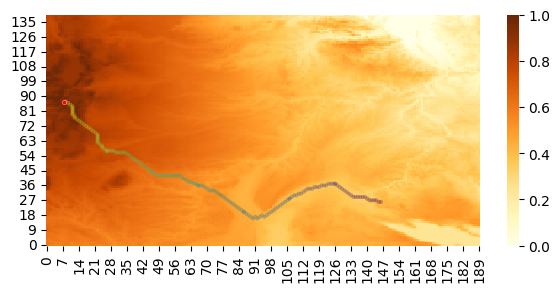

In [165]:
# Plotting the path
data1 = mapData.data[0:200,0:200]
data2 = total_path_taken

f, ax = plt.subplots(figsize=(7, 3))
# plt.tick_params(bottom='on')
ax = sns.heatmap(data1, cmap='YlOrBr')# , annot=True, fmt = '.4f', annot_kws = {"size": 5})

sns.scatterplot(x=data2[:,0]+0.5, y = data2[:,1]+0.5, hue = [i for i in range(len(data2[:,0]))], linewidth=2, ax=ax, palette='viridis', legend=False, markers='.', edgecolor=None, s = 1, alpha = 0.3)
sns.scatterplot(x=[target_index[0]], y=[target_index[1]], color='red', s=10)
ax.axis('tight')
ax.invert_yaxis()

plt.show()